In [18]:
from ecole.instance import SetCoverGenerator


generator = SetCoverGenerator(n_rows=50, n_cols=100, density=0.1, max_coef = 1)

for i in range(15):
    instance = next(generator)
    instance.write_problem(f"ecole_tests/rest/sc-50-100-{i + 85}.lp")


def parse_test_instance_from_file(file_path):
    with open(file_path, 'r') as file:
        input_text = file.read()

    lines = input_text.split("\n")
    num_variables = 0
    num_constraints = 0
    constraints = []
    variables = []

    # Parse the input text to extract constraints and variables
    for line in lines:
        if "Variables" in line:
            num_variables = int(line.split()[3])
            variables = [0] * num_variables  # Initialize variables list
        elif "Constraints" in line:
            num_constraints = int(line.split()[3])
        elif line.startswith(" c"):
            parts = line.split(":")[1].split(">=")[0].strip().split(" +")
            constraint = [0] * num_variables
            for part in parts:
                if part:
                    index = int(part.split("x")[1])
                    constraint[index] = 1
            constraints.append(constraint)
    
    # Check if data was parsed correctly
    if len(constraints) != num_constraints or len(variables) != num_variables:
        print("Error parsing the test instance.")
        return None, None
    
    return constraints, variables




In [6]:
class Node:
    def __init__(self, parent, node_key, zlb: list, zub: list, model = None, support = []):
        """
        Initialize a Node

        Parameters
        ----------
        parent: Node or None
            the parent Node
        
        node_key: Str
            Name associated with Node, used for Node Lookup

        """
        
        self.parent_dual = parent.dual_value if parent else None
        self.parent_primal = parent.primal_value if parent else None

        self.level = parent.level + 1 if parent else 0
        self.zlb = zlb
        self.zub = zub
        self.z = None

        self.upper_bound = None
        self.primal_value = None
        self.dual_value = None

        self.support = parent.support.copy() if parent and support is None else support
        self.upper_z = None
        self.primal_beta = None

        # Each node will store it's children's nodes and current state
        self.node_key = node_key
        self.opt_gap = 0
        self.parent_key = None
        self.is_leaf = True
        self.left = None
        self.right = None
        self.state = None
        

    def get_info(self):
        return f'node_key: {self.node_key}, is_leaf: {self.is_leaf}, ' \
            f'state: {self.state}'
    
    def assign_children(self, left_child=None, right_child=None):
        '''
        Function assigns children nodes to parent and 
        parent is set to no longer leaf

        inputs:
            left_child: Node associated with Left Child
            right_child: Node associated with Right Child
        '''
        if left_child is not None:
            self.left = left_child
            self.left.parent_key = self.node_key
            self.is_leaf = False
        
        if right_child is not None:
            self.right = right_child
            self.right.parent_key = self.node_key
            self.is_leaf = False

    def __str__(self):
        return f'level: {self.level}, lower cost: {self.primal_value}, ' \
            f'upper cost: {self.upper_bound}'

    def __repr__(self):
        return self.__str__()

    def __lt__(self, other):
        if self.level == other.level:
            if self.primal_value is None and other.primal_value:
                return True
            if other.primal_value is None and self.primal_value:
                return False
            elif not self.primal_value and not other.primal_value:
                return self.parent_primal > \
                       other.parent_cost
            return self.primal_value > other.lower_bound_value
        return self.level < other.level

In [7]:
from pyscipopt import Model, quicksum
import numpy as np

class Problem:
    
    def __init__(self, x, gap_tol=1e-1):
        
        self.x = np.array(x)
        self.gap_tol = gap_tol
        self.num_sets, self.num_universe_items = self.x.shape
        
        # States
        self.prob_stats, self.var_stats = self.get_static_stats()

    def lower_solve(self, node):
        """
        Solves the relaxed set cover problem (linear programming relaxation).

        Parameters:
            node (Node): The current node in the branch and bound tree.

        Returns:
            tuple: 
                - primal_value (float): The primal value of the solution.
                - dual_value (float): The dual value of the solution.
        """
        
        # Adding branching decisions from node state (zlb and zub)
        model = Model("SetCoverRelaxed")
        set_vars = [model.addVar(vtype="C", name=f"x_{i}") for i in range(self.num_sets)]
        # Constraints
        for j in range(self.num_universe_items):
            model.addCons(quicksum(self.x[i, j] * set_vars[i] for i in range(self.num_sets)) >= 1)
        # Objective
        model.setObjective(quicksum(set_vars), "minimize")
        
        lp_vars = [var for var in model.getVars()]
        for i in node.zlb:
            model.chgVarUb(lp_vars[i], 0)
        for i in node.zub:
            model.chgVarLb(lp_vars[i], 1)
        model.setIntParam("display/verblevel", 1)
        model.setParam("presolving/maxrounds", 0)
        model.setParam("presolving/maxrestarts", 0)
        model.optimize()

        ## check if solution is infeasible
        if model.getStatus() == "infeasible":
            #print("Infeasible")
            node.primal_value = 100000
            node.dual_value = 100000
            return np.inf, np.inf
        primal_value = model.getPrimalbound()
        dual_value = model.getDualbound()

        # Update the attributes of the provided Node instance
        node.primal_value = primal_value
        node.dual_value = dual_value
        node.primal_beta = [model.getVal(var) for var in lp_vars]
        node.z = [model.getVal(var) for var in lp_vars]
        node.support = [i for i, var in enumerate(lp_vars) if model.getVal(var) > 0 and i not in node.zub]
        return node.primal_value, node.dual_value
    
    def upper_solve(self, node):
        """
        Solves the set cover problem using LP rounding to provide an upper bound.

        Parameters:
            node (Node): The current node in the branch and bound tree.

        Returns:
            float: The cost of the selected sets (upper bound).
            list: Indices of selected sets.
        """
        num_sets, num_universe_items = self.x.shape
        set_costs = [1 for _ in range(len(self.x))]  # Assuming each set has a cost of 1
        threshold = 0.5
        selected_sets = [i for i, val in enumerate(node.z) if val >= threshold]

        # Ensure all items are covered
        for j in range(num_universe_items):
            if not any(self.x[i, j] for i in selected_sets):
                # Find the set with the highest fractional value that covers this item
                sets_covering_item = [i for i in range(num_sets) if self.x[i, j] > 0]
                max_contrib_set = max(sets_covering_item, key=lambda i: node.z[i])
                selected_sets.append(max_contrib_set)

        selected_sets = list(set(selected_sets))  # Remove duplicates
        upper_bound = sum(set_costs[i] for i in selected_sets)
        # print("At upperBound: ", upper_bound, "selected sets: ", selected_sets)
        node.upper_bound = upper_bound
        node.upper_z = [1 if i in selected_sets else 0 for i in range(len(self.x[0]))]
        return upper_bound
    
    def get_static_stats(self):
        """
        Computes and returns static statistics related to the set cover problem.

        Returns:
            tuple: A tuple containing two NumPy arrays:
                - prob_stats: Problem-level statistics.
                - var_stats: Variable-level statistics.
        """

        # Calculate set cover specific statistics
        set_costs = [1 for _ in range(self.num_sets)]  # Replace with actual costs if needed
        set_coverage = [np.sum(self.x[i]) for i in range(self.num_sets)]
        item_coverage = [np.sum(self.x[:, j]) for j in range(self.num_universe_items)]

        # Calculate overlap (e.g., Jaccard index)
        overlap = np.zeros((self.num_sets, self.num_sets))
        for i in range(self.num_sets):
            for j in range(i + 1, self.num_sets):
                intersection = np.sum(np.logical_and(self.x[i], self.x[j]))
                union = np.sum(np.logical_or(self.x[i], self.x[j]))
                overlap[i, j] = intersection / union
                overlap[j, i] = overlap[i, j]

        # Create NumPy arrays for prob_stats and var_stats
        prob_stats = np.array([
            self.num_sets,
            self.num_universe_items,
            # ... (Add other problem-level statistics)
        ])

        var_stats = np.zeros((self.num_sets, 4))  # Assuming 6 variable-level statistics
        for i in range(self.num_sets):
            var_stats[i] = np.array([
                set_costs[i],
                set_coverage[i],
                item_coverage[i],  # Add item coverage for each set
                overlap[i].mean(),  # Add average overlap with other sets
                # ... (Add other variable-level statistics)
            ])

        return prob_stats, var_stats
    

In [8]:
import numpy as np
from copy import deepcopy
from random import choice, choices
import math
from operator import attrgetter
from scipy import optimize as sci_opt

def reverse_lookup(d, val):
  for key in d:
    if d[key] == val:
      return key
    
class tree():
    def __init__(self, problem):
        self.problem = problem
        self.tree_stats = None
        # Algorithm variables - also reset with set_root below
        self.active_nodes = dict()      # Current Nodes
        self.all_nodes = dict()         # All Nodes
        self.step_counter = 0           # Number branch steps taken
        self.node_counter = 0
        self.best_int = math.inf            # Best integer solution objective value
        self.candidate_sol = None           # Best integer solution values
        self.lower_bound = None             # Minimum relaxed value of all nodes
        self.initial_optimality_gap = None  # Initial optimality gap from root node
        self.optimality_gap = None          # Current optimality gap
        self.root = None


    def start_root(self):
        # Initialize root node
        root_node = Node(parent=None, node_key='root_node', zlb=[], zub=[], support=list(range(self.problem.num_sets)))
        self.active_nodes['root_node'] = root_node
        self.all_nodes['root_node'] = root_node
        self.problem.lower_solve(root_node)
        self.problem.upper_solve(root_node)

        # Update bounds and opt gap
        self.lower_bound = root_node.primal_value
        if (root_node.upper_bound < self.best_int):
            self.best_int = root_node.upper_bound
            self.candidate_sol = root_node.upper_z
        self.initial_optimality_gap = (self.best_int - self.lower_bound) / self.lower_bound
        self.optimality_gap = self.initial_optimality_gap
        self.node_counter += 1
        self.tree_stats = self.get_tree_stats()
        # Start Tree
        self.root = self.active_nodes['root_node']
        # Return if done
        if self.check_integer_values(root_node) or (self.optimality_gap <= self.problem.gap_tol):
            return(True)
        return(False)

    def get_info(self):
        # Summary info of current state
        info = {'step_count': self.step_counter,
                'node_count': self.node_counter,
                'best_primal_value': self.best_int,
                'candidate_sol': self.candidate_sol,
                'lower_bound': self.lower_bound,
                'init_opt_gap' : self.initial_optimality_gap,
                'opt_gap': self.optimality_gap}
        return(info)

    def get_tree_stats(self):
        """
        Returns tree statistics

        Returns:
            numpy.ndarray: Tree specific statistics.
                - number of steps taken
                - number of active nodes
                - number of candidate solution variables
                - lower bound
                - best integer solution
                - initial optimality gap
                - current optimality gap
        """
        # Returns summary statisitics that describe the set of all active nodes
        tree_stats = np.array([self.step_counter,
                               len(self.active_nodes),
                               len(self.candidate_sol),
                               self.lower_bound,
                               self.best_int,
                               self.initial_optimality_gap,
                               self.optimality_gap])    
        return(tree_stats)
    
    def get_node_stats(self, node_key):
        """
        Returns node statistics

        Returns:
            numpy.ndarray: Node specific statistics.
                - length of zub
                - legth of zlb
                - node specific primal value
                - node depth level
                - legth of support
                - whether the node has the lower bound
                - whether the node has the upper bound
        """
        # Returns summary stats for a given node
        node = self.all_nodes[node_key]
        len_support = len(node.support) if node.support else 0
        has_lb = (self.lower_bound == node.primal_value)
        has_ub = (self.best_int == node.upper_bound)
        node_stats = np.array([len(node.zub),
                               len(node.zlb),
                               node.primal_value,
                               node.level,
                               len_support,
                               has_lb,
                               has_ub])
        return(node_stats)
    
    def get_var_stats(self, node_key, j):
        """
        Returns variable statistics

        Returns:
            numpy.ndarray: Node and Variable specific statistics.
                - primal beta
                - z value
                - upper z value 
        """        
        node = self.all_nodes[node_key]
        # Case when node has no support (used for retrobranching)
        if len(node.support) == 0: 
            print('No Support found for Node during Retrobranching')
            # Values chosen to show lack of information for agent
            return np.array([-1, 0])
        if node.primal_value > 1000: 
            print('Infeasible branch - leaf node')
            # Values chosen to show infeasible branch to agent
            return np.array([-1, 0])
        # Returns summary stats for branching on j in a node
        index = [i for i in range(len(node.support)) if node.support[i] == j][0]
        var_stats = np.array([node.z[index], node.upper_z[index]])
        
        return(var_stats)
    
    def get_state(self, node_key, j):
        '''
        Returns numpy array of 34 values containing problem and variable static states
        as well as tree, node, and variable current states.
        '''
        # Concatenates overall state for possible branch
        state = np.concatenate((self.problem.prob_stats,
                  self.problem.var_stats[j,:],
                    self.tree_stats,
                  self.get_node_stats(node_key),
                  self.get_var_stats(node_key, j)))

        return(state)
    
    def max_frac_branch(self):
        # Finds node with greatest fractional part
        # The goal of this function is more focused. It identifies the single best candidate (node and variable) for branching based on the criterion of having the maximum fractional part. This is a direct action function that pinpoints where the next branching should occur to efficiently progress toward an integer solution.
        # support in scip's context would mean the set of variables that have not been split on yet, meaning that they have no upper bound or lower bound set yet.
        best_node_key = None
        best_frac = 0
        best_index = None
        for node_key in self.active_nodes:
            node = self.active_nodes[node_key]
            z = [node.z[i] for i in node.support]
            diff = [min(1 - val, val) for val in z]
            max_diff = max(diff)
            potential_j_index = diff.index(max_diff)
            potential_j = node.support[potential_j_index]
            if max_diff > best_frac:
                best_node_key = node_key
                best_frac = max_diff
                best_index = potential_j
        return(best_node_key, best_index)

    def check_integer_values(self, node):
        """
        Checks if each value in node.z is an integer or a float representing an integer (e.g., 1.0).

        Parameters:
            node: The current node in the branch and bound tree, expected to have an attribute z.

        Returns:
            bool: True if all values in node.z are integers or floats representing integers, False otherwise.
        """
        return all(val.is_integer() if isinstance(val, float) else isinstance(val, int) for val in node.z)
    
    def prune(self, node_keys):
        # Iterate through node keys to find those that aren't active
        for node_key in node_keys:
            if self.active_nodes[node_key].primal_value > self.best_int:
                del self.active_nodes[node_key]

    def update_lower_bound(self):
        # Update the best lower bound over all active nodes
        if len(self.active_nodes) == 0:
            self.lower_bound = self.best_int
        else:
            self.lower_bound = min(self.active_nodes.values(), key=attrgetter('primal_value')).primal_value
            self.lower_bound_node_key = reverse_lookup(self.active_nodes, min(self.active_nodes.values(), key=attrgetter('primal_value')))

    def solve_node(self, node_key):
        # Solves a node with CD and updates upper bound 
        curr_node = self.active_nodes[node_key]
        ## here, the lower_solve could return an infeasible solution, so we need to check for that
        primal_value, _ = self.problem.lower_solve(curr_node)
        if primal_value > 100000:
            del self.active_nodes[node_key]
        else:
        # Update upper bound by rounding soln
            curr_upper_bound = self.problem.upper_solve(curr_node)
            if curr_upper_bound < self.best_int:
                self.best_int = curr_upper_bound
                self.candidate_sol = curr_node.upper_z
            # Check if an integer solution
            if self.check_integer_values(curr_node):
                if curr_node.primal_value < self.best_int:
                    self.best_int = curr_node.primal_value
                    self.candidate_sol = curr_node.primal_beta
                del self.active_nodes[node_key]

    def step(self, branch_node_key, j):
        # Add State to Node in Tree
        branch_node = self.active_nodes[branch_node_key]
        branch_node.state = self.get_state(branch_node_key, j)
        self.step_counter += 1

        # Create two child nodes
        branch_node = self.active_nodes[branch_node_key]
        new_zlb = branch_node.zlb + [j]
        new_zub = branch_node.zub + [j]
        # Branches for z_max_frac in node branch_node_key and returns True if done
        # Branch to z_max_frac to be 0
        new_support = [index for index in branch_node.support if index != j]
        
        node_name_1 = f'node_{self.node_counter}'
        self.active_nodes[node_name_1] = Node(parent=branch_node, node_key=node_name_1, zlb=new_zlb, zub=branch_node.zub, support=new_support)
        self.node_counter += 1

        # Branch to z_max_frac to be 1
        node_name_2 = f'node_{self.node_counter}'
        self.active_nodes[node_name_2] = Node(parent=branch_node, node_key=node_name_2, zlb=branch_node.zlb, zub=new_zub, support=new_support)
        self.node_counter += 1

        # Store New Nodes in all_nodes Dictionary
        self.all_nodes[node_name_1] = self.active_nodes[node_name_1]
        self.all_nodes[node_name_2] = self.active_nodes[node_name_2]

        # Store Child Nodes in Tree
        branch_node.assign_children(self.active_nodes[node_name_1], self.active_nodes[node_name_2])
        del self.active_nodes[branch_node_key] # Delete Parent from Active Nodes
        
        # Solve relaxations in new nodes
        
        past_upper = self.best_int
        ## solve_node will use the lower solve
        self.solve_node(node_name_1)
        self.solve_node(node_name_2)

        # Check for node eliminations based on upper bound
        if (past_upper > self.best_int):
            self.prune(list(self.active_nodes.keys()))
            
        # Update lower_bound and lower_bound_node_key
        self.update_lower_bound()

        # Update optimality gap
        old_gap = self.optimality_gap
        self.optimality_gap = (self.best_int - self.lower_bound) / self.lower_bound

        # Update Node optimality Gap
        branch_node.opt_gap = old_gap - self.optimality_gap

        self.tree_stats = self.get_tree_stats()
        # Return True if solved or within tolerance and False otherwise
        if (len(self.active_nodes) == 0) or (self.optimality_gap <= self.problem.gap_tol):
            return(True, old_gap, self.optimality_gap)
        
        return(False, old_gap, self.optimality_gap)

    def branch_and_bound(self):
        fin_solving = self.start_root()
        if fin_solving:
            return 1, self.candidate_sol, self.optimality_gap
        
        iters = 0
        
        while (not fin_solving) and (iters < 10000):
            # print(f'Iteration {iters}')
            node_key, j = self.max_frac_branch()
            # Take a step
            fin_solving, old_gap, new_gap = self.step(node_key, j)
            iters += 1
        return(iters, len(self.candidate_sol), self.optimality_gap)
    
    def get_state_pairs(self, node):
        '''
        Recursively collect tree edges, parent and child states pairs

        input:
            node: node of tree
        return:
            list of (previous state, state, reward) tuples
        '''
        pairs = []

        if not node:
            return pairs

        # Function to categorize rewards inline
        categorize_reward = lambda opt_gap: 1 if 0 < opt_gap <= 0.05 else 2 if 0.05 < opt_gap <= 0.15 else 3 if opt_gap > 0.15 else -1

        # Check left child
        if node.left:
            reward = 0 if node.left.is_leaf else categorize_reward(node.left.opt_gap)
            pairs.append((node.state, node.left.state, reward))
            pairs.extend(self.get_state_pairs(node.left))

        # Check right child
        if node.right:
            reward = 0 if node.right.is_leaf else categorize_reward(node.right.opt_gap)
            pairs.append((node.state, node.right.state, reward))
            pairs.extend(self.get_state_pairs(node.right))

        return pairs

In [9]:
def load_problem_instances(file_paths):
    problem_instances = []
    for file_path in file_paths:
        x, variables = parse_test_instance_from_file(file_path)
        problem_instances.append(Problem(x))
    return problem_instances

def solve_with_branch_and_bound(problem_instances):
    bb_metrics = []
    iterationsOnly = []
    i = 0
    for instance in problem_instances:
        # Create a new Tree object
        newTree = tree(instance)
        # Solve the problem using the general branch and bound algorithm
        iterations, _, opt_gap = newTree.branch_and_bound()
        # Store the branch and bound metrics for the instance
        bb_metrics.append((iterations, opt_gap))
        iterationsOnly.append(iterations)
        print("Solved instance ", i," in ", iterations, " iterations.")
        i += 1
    
    return bb_metrics, iterationsOnly
  
file_paths = [ "ecole_tests/sc-100-100-0.05/sc-100-100-0.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-1.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-2.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-3.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-4.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-5.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-6.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-7.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-8.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-9.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-10.lp",
               "ecole_tests/sc-100-100-0.05/sc-100-100-11.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-12.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-13.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-14.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-16.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-17.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-18.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-19.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-20.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-21.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-22.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-23.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-24.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-25.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-26.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-27.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-28.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-29.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-30.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-31.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-32.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-33.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-34.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-35.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-36.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-37.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-38.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-39.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-40.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-41.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-42.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-43.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-44.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-45.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-46.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-47.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-48.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-49.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-50.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-51.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-52.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-53.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-54.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-55.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-56.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-57.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-58.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-59.lp",
                "ecole_tests/sc-100-100-0.05/sc-100-100-60.lp",]
problem_instances = load_problem_instances(file_paths)
    

In [10]:
import random
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
from settings import MAX_ITERS, EPSILON_START, EPSILON_END, EPSILON_DECAY, BATCH_SIZE, INT_EPS, GAMMA, TARGET_UPDATE

EPSILON_DECAY = 0.999
# Memory representation of states
Transition = namedtuple('Transition', 
                        ('prev_state', 'state', 'reward'))

# Deep Q Network
class DQN(nn.Module):
    def __init__(self, input_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        output1 = F.leaky_relu(self.fc1(x))
        output2 = F.leaky_relu(self.fc2(output1))
        output = self.fc3(output2)
        return(output)

# Memory for our agent
class Memory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Agent that performs, remembers and learns actions
class Agent():
    def __init__(self, n):
        self.policy_net = DQN(n)
        self.target_net = DQN(n)
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = Memory(10000)
        self.episodes_played = 0
        self.epsilon = EPSILON_START
        self.epsilon_decay = EPSILON_DECAY
        self.epsilon_end = EPSILON_END

    def retrobranch(self, tree):
        """
        Complete all leaf states in finished tree, then store all state pairs in memory
        Uses max_frac_branch for completing tree for efficiency
        Checks if episodes_played divisible by TARGET_UPDATE, if so updates target network

        Parameters
        ----------
        tree: Tree Class
            the finished tree for retrobranching
        
        total_reward: Int
            total reward for playing through tree
        """

        # Complete Tree -- Get (Non-Optimal) States for Leaf Nodes
        for node in tree.all_nodes.values():
            if node.state is None: 
                if len(node.support) == 0:
                    best_j = 0
                # Select a best_j 
                else:
                    # z = node.z
                    # support = node.support
                    # diff = [min(1-z[i], z[i]-0) for i in range(len(support))]
                    # best_j = support[np.argmax(diff)]
                    if node.z is None:
                        if len(node.support) != 0:
                            best_j = node.support[0]
                    else:
                        z = [node.z[i] for i in node.support]
                        diff = [min(1 - val, val) for val in z]
                        max_diff = max(diff)
                        potential_j_index = diff.index(max_diff)
                        best_j = node.support[potential_j_index]
            
                node.state = tree.get_state(node.node_key, best_j)

        # Set rewards
        total_reward = 0

        # Call tree function to create all state to state pairs
        state_pairs = tree.get_state_pairs(tree.root)

        # Sample 128 state pairs if there are more than 128, otherwise use all
        sample_size = 128
        if len(state_pairs) > sample_size:
            sampled_pairs = random.sample(state_pairs, sample_size)
        else:
            sampled_pairs = state_pairs
        
        for prev, curr, r in sampled_pairs:
            
            total_reward += r
            curr_list = curr.tolist()
            if None in curr:
                print("curr", type(curr), curr)
            if None in prev:
                print("prev",type(prev), prev)
            
            # # Add state pairs and reward to memory 
            # self.memory.push(torch.tensor(np.array([prev]), dtype=torch.float), 
            #                  torch.tensor(np.array([curr]), dtype=torch.float), 
            #                  torch.tensor([r], dtype=torch.float))
            # Convert the array to a list and replace None with a suitable numerical value
            
            curr_list = [0.0 if x is None else x for x in curr_list]

            # Convert the modified list back to a NumPy array
            curr_array = np.array([curr_list])

            # Add state pairs and reward to memory
            self.memory.push(torch.tensor(np.array([prev]), dtype=torch.float),
                            torch.tensor(curr_array, dtype=torch.float),
                            torch.tensor([r], dtype=torch.float))
        
        # Update target network
        if self.episodes_played % TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return total_reward

    def select_action(self, T):
        """
        Select an optimal node and j to split on given a tree

        Parameters
        ----------
        T: Tree Class
            the tree to select an action on
        
        best_node_key: Str
            string tied to the node to split on
        best_j: Int
            int representing the variable to split on
        """

        # Select an action according to an epsilon greedy approach        
        if (random.random() < self.epsilon):
            # max fraction branching
            best_node_key, best_j = T.max_frac_branch()
        else:
            # calculate estimated value for all nodes
            best_val = -math.inf
            best_node_key = None
            best_j = 0

            for node_key in T.active_nodes:
                support = T.active_nodes[node_key].support
                for i in range(len(support)):
                    if (T.active_nodes[node_key].z[i] < INT_EPS) or (T.active_nodes[node_key].z[i] > 1-INT_EPS):
                        continue
                    state = torch.tensor(np.array([T.get_state(node_key, support[i])]), dtype=torch.float)
                    # Agent estimates usings policy network
                    val = self.policy_net(state) 
                    if(val > best_val):
                        best_val = val
                        best_node_key = node_key
                        best_j = support[i]

        return(best_node_key, best_j)
    
    def replay_memory(self):
        """
        Samples a BATCH_SIZE number of items from memory, optimizes and updates policy network
        """

        # Only Replay Memory if enough enteries in Memory
        if len(self.memory) < BATCH_SIZE:
            return
        
        # Sample from our memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Concatenate our tensors for previous states
        prev_state_batch = torch.cat(batch.prev_state)
        state_batch = torch.cat(batch.state)
        reward_batch = torch.cat(batch.reward)

        # Predict Q-values for the previous states
        pred_q_values = self.policy_net(prev_state_batch)
        pred_q_values = pred_q_values.squeeze(1) # Match shape of targets

        # Compute expected Q-values based on next states and rewards
        with torch.no_grad():
            max_next_q_values = torch.flatten(self.target_net(state_batch))
            targets = reward_batch + GAMMA * max_next_q_values

        # Compute loss
        loss_f = nn.MSELoss()
        loss = loss_f(pred_q_values, targets)

        # Optimization
        self.optimizer.zero_grad()
        loss.backward()

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)

        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay
        
        # Update Parameters
        self.optimizer.step()


    def RL_solve(self, T, training=True): # Give it a Tree
        # Solving an instance using agent to make choices in tree
        fin_solving = T.start_root()
        if fin_solving:
            print("Optimal solution found at the root node.")
            return 0, len(T.candidate_sol), T.optimality_gap
        # fin_solving = T.start_root()
        iters = 0
        tot_reward = 0

        while (fin_solving == False) and (iters < 5000):
            # Select and perform an action
            node, j = self.select_action(T)
            fin_solving, old_gap, new_gap = T.step(node, j) 

            iters += 1
        tot_reward = self.retrobranch(T)
        
        if training:
            # Store tree in memory and get total reward for tree
            

            # Optimize the target network using replay memory 
            # 128 iters after each episode
            for i in range(8):
                self.replay_memory()

            # Update number of episodes Agent has played
            self.episodes_played += 1
            
        return iters, tot_reward, len(T.candidate_sol), T.optimality_gap

In [47]:
print(EPSILON_DECAY)

def train_rl_model(problem_instances):
    agent = Agent(22)  # Initialize the RL agent with the appropriate input size
    training_metrics = []
    iterationsOnly = []
    epsilons = []
    i = 0

    for instance in problem_instances:
        newTree = tree(instance)
        
        # Solve the problem using the RL model
        iterations, total_reward, candidate_sol_length, opt_gap = agent.RL_solve(newTree, training=True)
        
        # Store the training metrics for the episode
        training_metrics.append((iterations, total_reward, candidate_sol_length, opt_gap))
        iterationsOnly.append(iterations)
        epsilons.append(agent.epsilon)
        # Print or log the training metrics for the episode
        print(f"Episode: {i} Iterations={iterations}, Total Reward={total_reward}, "
              f"Epsilon={agent.epsilon}, Optimality Gap={opt_gap}")
        i += 1
    return agent, training_metrics, iterationsOnly

    
    
def evaluate_rl_model(agent, test_instances):
    rl_metrics = []
    iterationsOnly = []
    epsilons = []
    i = 0
    for instance in test_instances:
        # Create a new Tree object
        newTree = tree(instance)
        # Solve the problem using the trained RL model
        iterations, total_reward, candidate_sol_length, opt_gap = agent.RL_solve(newTree, training=False)
        epsilons.append(agent.epsilon)
        # Store the evaluation metrics for the test instance
        rl_metrics.append((iterations, total_reward, opt_gap))
        iterationsOnly.append(iterations)
        print(f"Episode: {i} Iterations={iterations}, Total Reward={total_reward}, "
              f"Epsilon={agent.epsilon}, Optimality Gap={opt_gap}")
        i += 1
    return rl_metrics, iterationsOnly

trained_agent, trainingmetrics, RLiterationsOnly = train_rl_model(problem_instances)
print(RLiterationsOnly)
torch.save(trained_agent.policy_net.state_dict(), "saved_models/sc-100-100-0.10.pt")    # Save Policy Net



0.999
Episode: 0 Iterations=747, Total Reward=-69, Epsilon=0.9821076646292445, Optimality Gap=0.07279151943462907
Episode: 1 Iterations=8, Total Reward=0, Epsilon=0.9742782473974836, Optimality Gap=0.057301293900184895
Episode: 2 Iterations=584, Total Reward=-51, Epsilon=0.9665112467177939, Optimality Gap=0.09822047608042526
Episode: 3 Iterations=5, Total Reward=2, Epsilon=0.9588061650019316, Optimality Gap=0.09259373903712408
Episode: 4 Iterations=12, Total Reward=-3, Epsilon=0.9511625086284538, Optimality Gap=0.06320907617504047
Episode: 5 Iterations=5, Total Reward=4, Epsilon=0.9435797879110953, Optimality Gap=0.04617282500146851
Episode: 6 Iterations=7, Total Reward=-1, Epsilon=0.9360575170673977, Optimality Gap=0.023255813953488372
Episode: 7 Iterations=16, Total Reward=-4, Epsilon=0.9285952141875872, Optimality Gap=0.0880717058140931
Episode: 8 Iterations=153, Total Reward=-49, Epsilon=0.9211924012037015, Optimality Gap=0.09899114592201598
Episode: 9 Iterations=10, Total Reward=-

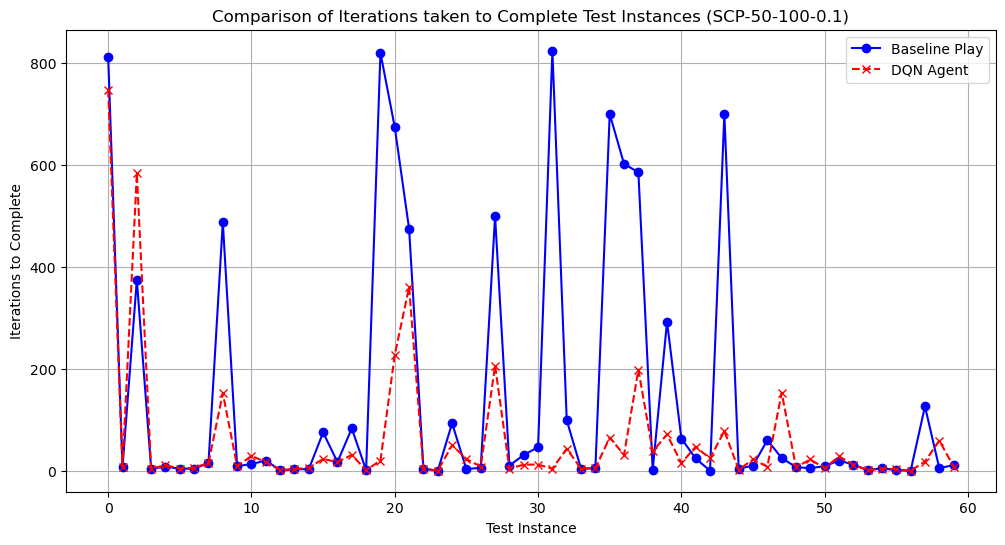

In [50]:
import matplotlib.pyplot as plt
# Plotting the results
plt.figure(figsize=(12, 6))
# iterationsOnly = [34, 239, 17, 367, 13, 13, 73, 38, 1, 246, 1, 33, 240, 12, 160, 8, 724, 6, 3, 122, 92, 318, 774, 561, 539, 774, 14, 256, 2, 887, 3, 756, 261, 101, 4, 17, 2, 219, 520, 568, 283]
# iterationsOnly = [34, 239, 4891, 17, 367, 13, 13, 73, 38, 1, 246, 1, 33, 240, 12, 160, 1747, 8, 724, 5000, 3059, 2110, 1052, 2263, 947, 6, 1095, 3, 1469, 122, 5000, 92, 318, 774, 561, 539, 774, 1149, 14, 256, 1980, 4435, 2, 887, 3, 756, 2092, 5000, 261, 101, 4, 17, 2, 219, 520, 4299, 993, 568, 283, 16]
iterationsOnly = [812, 8, 375, 5, 9, 5, 5, 16, 488, 10, 14, 21, 2, 4, 4, 76, 18, 84, 2, 820, 674, 475, 5, 1, 94, 4, 7, 500, 11, 32, 47, 824, 100, 5, 6, 700, 602, 586, 3, 293, 64, 25, 1, 700, 5, 11, 61, 26, 8, 6, 10, 21, 13, 2, 6, 2, 1, 127, 6, 12]
plt.plot(iterationsOnly, marker='o', linestyle='-', color='blue', label='Baseline Play')
plt.plot(RLiterationsOnly, marker='x', linestyle='--', color='red', label='DQN Agent')

plt.xlabel('Test Instance')
plt.ylabel('Iterations to Complete')
plt.title('Comparison of Iterations taken to Complete Test Instances (SCP-50-100-0.1)')
plt.legend()

plt.grid(True) 
plt.show()

In [68]:
print(RLiterationsOnly)

[34, 8, 325, 17, 100, 13, 7, 102, 66, 1, 216, 1, 44, 380, 10, 22, 1124, 8, 32, 43, 53, 388, 14, 5000, 149, 6, 55, 3, 437, 57, 2954, 16, 52, 77, 5000, 178, 14, 21, 8, 90, 2924, 10, 2, 41, 4, 50, 235, 790, 43, 207, 3, 24, 3, 27, 126, 127, 119, 30, 32, 45]


In [17]:
file_paths = ["ecole_tests/sc-50-100-61.lp",
                "ecole_tests/sc-50-100-62.lp",
                "ecole_tests/sc-50-100-63.lp",
                "ecole_tests/sc-50-100-64.lp",
                "ecole_tests/sc-50-100-65.lp",
              "ecole_tests/sc-50-100-66.lp",
                "ecole_tests/sc-50-100-67.lp",
                "ecole_tests/sc-50-100-68.lp",
                "ecole_tests/sc-50-100-69.lp",
                "ecole_tests/sc-50-100-70.lp",
              "ecole_tests/sc-50-100-71.lp",
                "ecole_tests/sc-50-100-72.lp",
                "ecole_tests/sc-50-100-73.lp",
                "ecole_tests/sc-50-100-74.lp",
                "ecole_tests/sc-50-100-75.lp",
                "ecole_tests/sc-50-100-76.lp"]
# [41, 122, 6, 11, 5, 56, 6, 69, 28, 46, 46, 3, 7, 2, 133, 55]
test_instances = load_problem_instances(file_paths)
_, BBiterationsOnly = solve_with_branch_and_bound(test_instances)
rlmetrics, RLiterationsOnly = evaluate_rl_model(trained_agent, test_instances)
print(BBiterationsOnly)
print(RLiterationsOnly)

Solved instance  0  in  228  iterations.
Solved instance  1  in  1169  iterations.
Solved instance  2  in  3  iterations.
Solved instance  3  in  23  iterations.
Solved instance  4  in  32  iterations.
Solved instance  5  in  109  iterations.
Solved instance  6  in  2933  iterations.
Solved instance  7  in  729  iterations.
Solved instance  8  in  3149  iterations.
Solved instance  9  in  75  iterations.
Solved instance  10  in  525  iterations.
Solved instance  11  in  3  iterations.
Solved instance  12  in  3  iterations.
Solved instance  13  in  176  iterations.
Solved instance  14  in  5000  iterations.
Solved instance  15  in  795  iterations.
Infeasible branch - leaf node
Episode: 0 Iterations=41, Total Reward=-21, Epsilon=0.612448454530214, Optimality Gap=0.06719367588932808
Episode: 1 Iterations=122, Total Reward=-29, Epsilon=0.612448454530214, Optimality Gap=0.08228980322003572
Episode: 2 Iterations=6, Total Reward=5, Epsilon=0.612448454530214, Optimality Gap=0.079511315842179

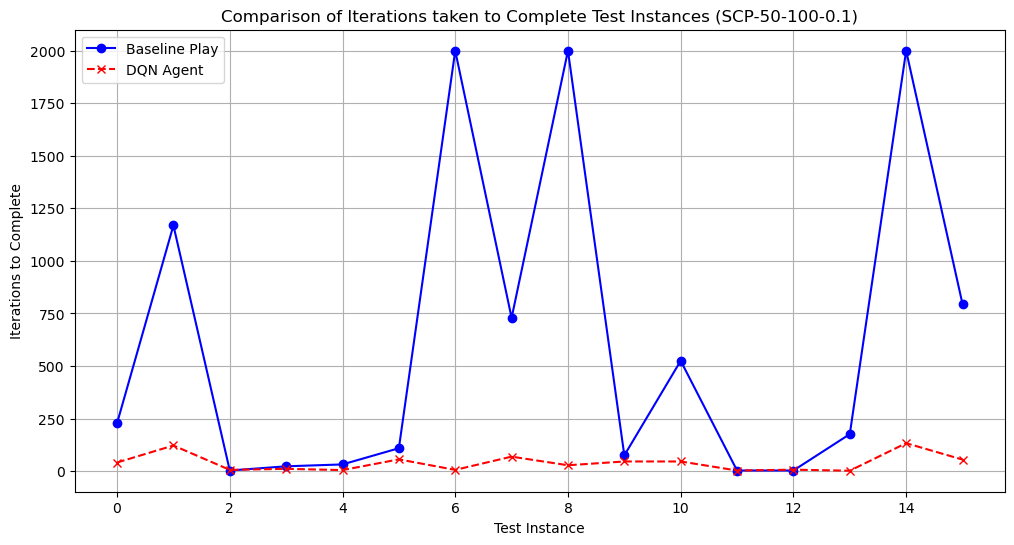

In [18]:
import matplotlib.pyplot as plt
# Plotting the results
plt.figure(figsize=(12, 6))
BBiterationsOnly = [228, 1169, 3, 23, 32, 109, 2000, 729, 2000, 75, 525, 3, 3, 176, 2000, 795]

plt.plot(BBiterationsOnly, marker='o', linestyle='-', color='blue', label='Baseline Play')
plt.plot(RLiterationsOnly, marker='x', linestyle='--', color='red', label='DQN Agent')

plt.xlabel('Test Instance')
plt.ylabel('Iterations to Complete')
plt.title('Comparison of Iterations taken to Complete Test Instances (SCP-50-100-0.1)')
plt.legend()

plt.grid(True) 
plt.show()

In [ ]:
## Reinforcement Learning ##

import matplotlib.pyplot as plt

agent = Agent(14)

import numpy as np
file_path = "ecole_tests/sc-50-100-1.lp"  # Replace with the path to your file
x, variables = parse_test_instance_from_file(file_path)
x = np.array(x)
# Lists to store results
max_iters = []
rl_iters = []
epsilons = []
newProblem = Problem(x)
# Play through 100 episodes using both methods
for episode in range(20):
    # Reset the tree for a new game
    newTree = tree(newProblem)

    # Play using the baseline method
    iters, _, _ = newTree.branch_and_bound()
    max_iters.append(iters)

    # Play using the RL agent
    iters,_,_,_ = agent.RL_solve(newTree)
    rl_iters.append(iters)
    epsilons.append(agent.epsilon)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(max_iters, label='Baseline Play')
plt.plot(rl_iters, label='DQN Agent')
plt.xlabel('Episode')
plt.ylabel('Iterations to Complete')
plt.title('Iterations per Episode')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')

plt.tight_layout()
plt.show()
